In [ ]:
!pip install rasterio

In [ ]:
import geemap
import geopandas as gpd
import folium
from shapely.geometry import shape
import rasterio

In [ ]:
# prompt: mount google drive navigate to dir GEE_Exports

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/My Drive/GEE_Exports/shapefiles/Dakar_data')


Mounted at /content/drive


In [ ]:
ls

'Action Items and Progress.gdoc'
 BRT_full_line.gpkg
 buffer_presence_change_shapefiles/
 buffer_presence_pre_shapefiles/
 buffer_pre_shapefiles/
 buffer_summary_shapefiles/
 building_height_2016_polygons/
 building_height_2023_polygons/
 building_height_diff_and_change_polygons/
 building_presence_2016/
 building_presence_2023/
 building_presence_change_polygons/
 classified_landuse.gpkg
 dakar_2016_projected.tif
 dakar_2023_projected.tif
 dakar_7layer_stack.csv
 dakar_7layer_stack.tif
 dakar_7layer_stack_utm.tif
 dakar_7layer_stack_with_coords.csv
 dakar_building_presence_height_2016.tif
 dakar_building_presence_height_2023.tif
 dakar_buildings/
 dakar_landuse_combined.gpkg
 Dakar_zones/
'Documentation of Zonal Influence Maps.gdoc'
 eo4sd_dakar_lulchr_2018/
 eo4sd_dakar_lulcvhr_2018/
 height_change_scaled.png
 presence_class_change.png
 raw_height_change.png
 raw_presence_change.png
 stationsofBRT1.gpkg
 ter_full_line/
 zone_buffer_exports/
 zone_buffer_exports_16/
 zone_buffer_prese

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_raster(src_path, dst_path, dst_crs="EPSG:32628"):
    with rasterio.open(src_path) as src:
        # Calculate transform and shape for the new CRS
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        # Copy metadata and update it for the new raster
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        # Open destination file and write reprojected bands
        with rasterio.open(dst_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

# Reproject 2016
reproject_raster(
    src_path="../raw/dakar_building_presence_height_2016.tif",
    dst_path="../generated/dakar_2016_projected.tif"
)

# Reproject 2023
reproject_raster(
    src_path="../raw/dakar_building_presence_height_2023.tif",
    dst_path="../generated/dakar_2023_projected.tif"
)

In [ ]:
tif_2016 = rasterio.open("../generated/dakar_2016_projected.tif")
tif_2023 = rasterio.open("../generated/dakar_2023_projected.tif")

# Confirm projection
print(tif_2016.crs)  # EPSG:32628
print(tif_2016.transform)  # Affine with pixel size in meters

# Example: pixel size
print("Pixel size:", tif_2016.transform.a, "meters")

EPSG:32628
| 3.92, 0.00, 198184.19|
| 0.00,-3.92, 1671334.99|
| 0.00, 0.00, 1.00|
Pixel size: 3.915940226045427 meters


In [ ]:
import rasterio

# Open 2016 projected raster and extract metadata, transform, shape
with rasterio.open("../generated/dakar_2016_projected.tif") as tif_2016:
    meta = tif_2016.meta.copy()
    transform = tif_2016.transform
    shape = tif_2016.read(1).shape
    presence_2016 = tif_2016.read(1)  # Band 1 = presence
    height_2016 = tif_2016.read(2)    # Band 2 = height

# Open 2023 projected raster and read bands
with rasterio.open("../generated/dakar_2023_projected.tif") as tif_2023:
    presence_2023 = tif_2023.read(1)
    height_2023 = tif_2023.read(2)

# Optional: confirm shapes match
assert presence_2016.shape == height_2016.shape
assert presence_2023.shape == height_2023.shape
assert presence_2016.shape == presence_2023.shape

# Optional: confirm values
print("Presence 2016 min/max:", presence_2016.min(), presence_2016.max())
print("Height 2016 min/max:", height_2016.min(), height_2016.max())
print("Presence 2023 min/max:", presence_2023.min(), presence_2023.max())
print("Height 2023 min/max:", height_2023.min(), height_2023.max())

Presence 2016 min/max: nan nan
Height 2016 min/max: nan nan
Presence 2023 min/max: nan nan
Height 2023 min/max: nan nan


In [ ]:
import numpy as np

presence_2016_masked = np.ma.masked_invalid(presence_2016)
height_2016_masked = np.ma.masked_invalid(height_2016)

presence_2023_masked = np.ma.masked_invalid(presence_2023)
height_2023_masked = np.ma.masked_invalid(height_2023)

print("Presence 2016 masked min/max:", presence_2016_masked.min(), presence_2016_masked.max())
print("Height 2016 masked min/max:", height_2016_masked.min(), height_2016_masked.max())

print("Presence 2016 nan count:", np.isnan(presence_2016).sum())
print("Height 2016 nan count:", np.isnan(height_2016).sum())

Presence 2016 masked min/max: 0.0 1.0
Height 2016 masked min/max: 0.0 94.52344
Presence 2016 nan count: 137741
Height 2016 nan count: 137741


In [ ]:
import rasterio
import geopandas as gpd
from rasterio.features import rasterize
from scipy.ndimage import distance_transform_edt

# Open projected raster
with rasterio.open("../generated/dakar_2016_projected.tif") as tif_proj:
    raster_crs = tif_proj.crs
    shape = tif_proj.read(1).shape
    transform = tif_proj.transform

print("Projected Raster CRS:", raster_crs)
print("Pixel size (meters):", transform.a)

# Load vector layers
brt = gpd.read_file("../raw/BRT_full_line.gpkg")
ter = gpd.read_file("../raw/ter_full_line/")

# Reproject vectors to raster CRS if needed
if brt.crs != raster_crs:
    brt = brt.to_crs(raster_crs)
if ter.crs != raster_crs:
    ter = ter.to_crs(raster_crs)

def rasterized_distance(gdf, shape, transform):
    mask = rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )
    dist = distance_transform_edt(mask == 0) * transform.a  # pixel size in meters
    return dist

distance_brt = rasterized_distance(brt, shape, transform)
distance_ter = rasterized_distance(ter, shape, transform)

print("Distance BRT shape:", distance_brt.shape)
print("Distance TER shape:", distance_ter.shape)

Projected Raster CRS: EPSG:32628
Pixel size (meters): 3.915940226045427
Distance BRT shape: (17179, 19437)
Distance TER shape: (17179, 19437)


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

# Reproject land use
landuse = gpd.read_file("../generated/dakar_landuse_combined.gpkg").to_crs(tif_2016.crs)

# Encode land use classes
landuse['LandUseCode'] = landuse['LandUseClass'].astype('category').cat.codes
landuse_mapping = dict(enumerate(landuse['LandUseClass'].astype('category').cat.categories))

# Rasterize
landuse_raster = rasterize(
    [(geom, val) for geom, val in zip(landuse.geometry, landuse["LandUseCode"])],
    out_shape=shape,
    transform=transform,
    fill=1,
    all_touched=True,
    dtype='uint8'
)

# Stack
stack = np.stack([
    presence_2016_masked,
    height_2016_masked,
    presence_2023_masked,
    height_2023_masked,
    distance_brt,
    distance_ter,
    landuse_raster.astype("float32")
], axis=0)

# Update meta
stack_meta = meta.copy()
stack_meta.update({
    "count": 7,
    "dtype": "float32"
})

# Write to disk
with rasterio.open("../output/dakar_7layer_stack.tif", "w", **stack_meta) as dst:
    dst.write(stack.astype("float32"))

In [ ]:
# import rasterio
# import numpy as np

# # Open the file
# with rasterio.open("../output/dakar_7layer_stack.tif") as src:
#     stack = src.read()           # shape: (7, height, width)
#     meta = src.meta              # metadata if needed

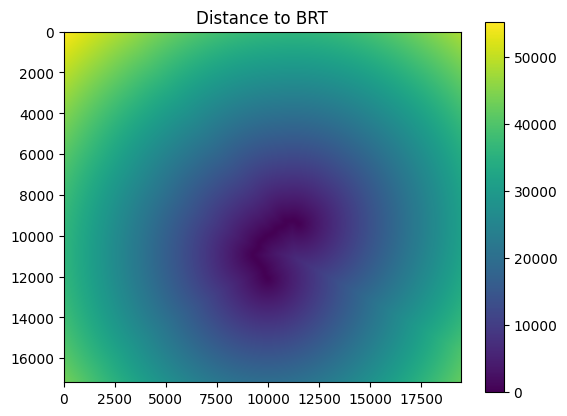

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(stack[4])  # Distance to BRT
plt.colorbar()
plt.title("Distance to BRT")
plt.show()

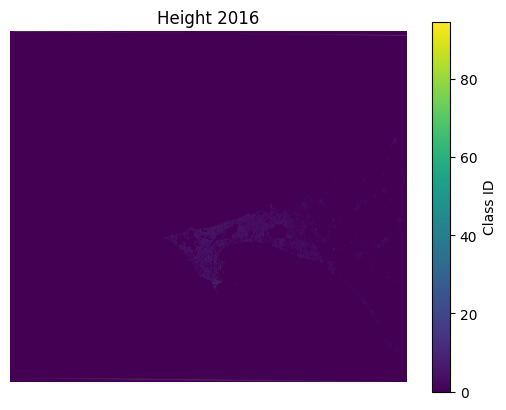

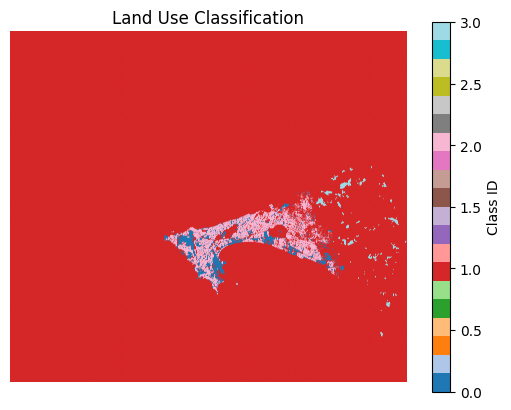

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(stack[1], cmap='viridis')
plt.title("Height 2016")
plt.colorbar(label="Class ID")
plt.axis("off")
plt.show()

plt.imshow(stack[6], cmap='tab20')
plt.title("Land Use Classification")
plt.colorbar(label="Class ID")
plt.axis("off")
plt.show()

In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np
import csv
from tqdm import tqdm  # progress bar

# Output path
output_csv = "../output/dakar_7layer_stack_with_coords.csv"

# Column names
columns = [
    "x", "y",
    "presence_2016", "height_2016",
    "presence_2023", "height_2023",
    "distance_brt", "distance_ter",
    "landuse_label"
]

landuse_map = {
    0: "Commercial",
    1: "Other",
    2: "Residential",
    3: "Unclassified Artificial Surfaces"
}

chunk_size = 512 # adjust based on memory

with rasterio.open("../output/dakar_7layer_stack.tif") as src, open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(columns)

    height, width = src.height, src.width
    transform = src.transform

    num_chunks = (height + chunk_size - 1) // chunk_size

    for row_start in tqdm(range(0, height, chunk_size), total=num_chunks, desc="Processing rows"):
        num_rows = min(chunk_size, height - row_start)
        window = Window(0, row_start, width, num_rows)

        data = src.read(indexes=[1, 2, 3, 4, 5, 6, 7], window=window)

        # Get x/y coordinates in batch
        rows, cols = np.meshgrid(
            np.arange(row_start, row_start + num_rows),
            np.arange(width),
            indexing="ij"
        )
        xs, ys = rasterio.transform.xy(transform, rows, cols)
        xs = np.array(xs).flatten()
        ys = np.array(ys).flatten()

        # Reshape data for row-wise iteration
        data = data.reshape(7, -1).T  # shape: (rows*width, 7)

        for i, pixel in enumerate(data):
            if not np.any(np.isnan(pixel)):
                row_vals = [xs[i], ys[i]] + pixel.tolist()
                row_vals[-1] = landuse_map.get(int(row_vals[-1]), "Unknown")
                writer.writerow(row_vals)

Processing rows: 100%|██████████| 34/34 [55:34<00:00, 98.07s/it]


In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm

records = []
chunk_size = 512

landuse_map = {
    0: "Commercial",
    1: "Other",
    2: "Residential",
    3: "Unclassified Artificial Surfaces"
}

building_thresh = 0.1

pixel_id = 0  # Unique ID for each pixel

with rasterio.open("../output/dakar_7layer_stack.tif") as src:
    height, width = src.height, src.width

    for row_start in tqdm(range(0, height, chunk_size)):
        num_rows = min(chunk_size, height - row_start)
        window = Window(0, row_start, width, num_rows)

        data = src.read(window=window)
        data = data.reshape(7, -1).T

        for pixel in data:
            if np.any(np.isnan(pixel)):
                continue

            pres16, h16, pres23, h23, dist_brt, dist_ter, landuse_code = pixel

            # Exclude demolished buildings
            if pres23 - pres16 < 0:
                continue

            if pres23 < building_thresh:
                continue

            dist = min(dist_brt, dist_ter)
            if dist > 2000:
                continue

            treatment = 1 if dist <= 1000 else 0
            landuse = landuse_map.get(int(landuse_code), "Unknown")

            # Add two rows per pixel: one for 2016 (pre), one for 2023 (post)
            records.append({
                "pixel_id": pixel_id,
                "year": 2016,
                "post": 0,
                "treatment": treatment,
                "presence": pres16,
                "height": h16,
                "landuse": landuse
            })
            records.append({
                "pixel_id": pixel_id,
                "year": 2023,
                "post": 1,
                "treatment": treatment,
                "presence": pres23,
                "height": h23,
                "landuse": landuse
            })

            pixel_id += 1

# Create panel DataFrame
df = pd.DataFrame(records)

# Compute height change using DiD: height ~ treatment * post + controls
model = smf.ols("height ~ treatment * post + C(landuse)", data=df).fit()

print(model.summary())

100%|██████████| 34/34 [29:31<00:00, 52.09s/it]


                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                 2.033e+05
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        00:58:24   Log-Likelihood:            -1.6842e+07
No. Observations:             6274992   AIC:                         3.368e+07
Df Residuals:                 6274985   BIC:                         3.368e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/tmp/ipython-input-6-919552483.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=grouped, x="landuse", y="height", hue="Year", ci=None)


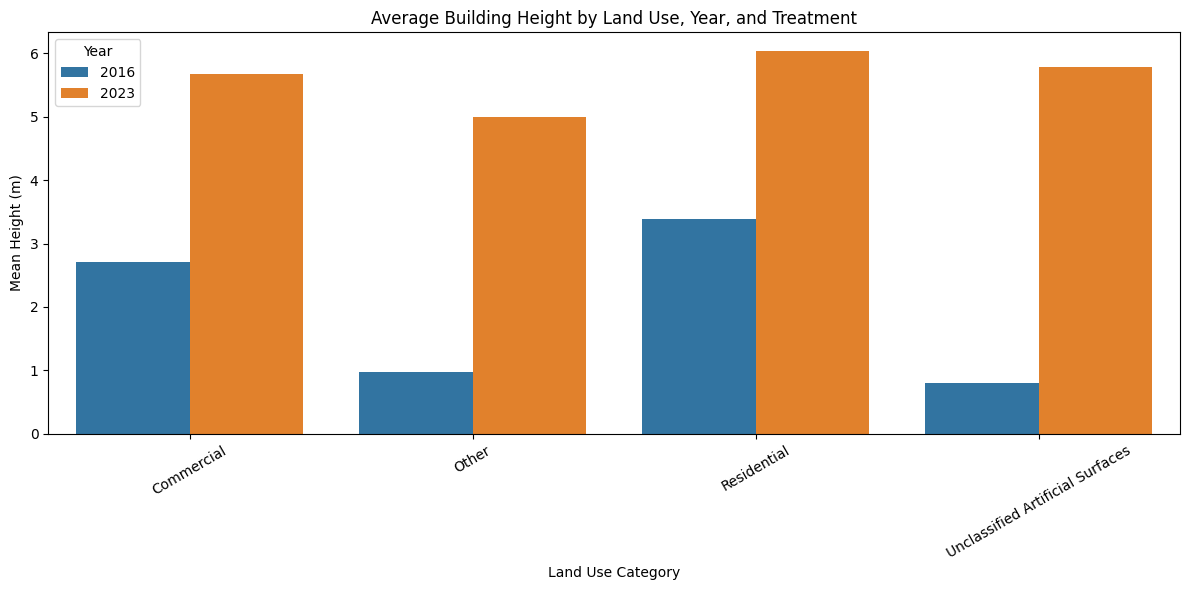

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute mean height per group
grouped = df.groupby(["landuse", "post", "treatment"])["height"].mean().reset_index()

# Replace numeric codes
grouped["Treatment Group"] = grouped["treatment"].map({0: "Control", 1: "Treated"})
grouped["Year"] = grouped["post"].map({0: "2016", 1: "2023"})

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=grouped, x="landuse", y="height", hue="Year", ci=None)
plt.title("Average Building Height by Land Use, Year, and Treatment")
plt.ylabel("Mean Height (m)")
plt.xlabel("Land Use Category")
plt.xticks(rotation=30)
plt.legend(title="Year")
plt.tight_layout()
plt.show()
plt.savefig("../output/1_2control/height_by_landuse_year.png")

In [ ]:
summary_df = model.summary2().tables[1]  # Coefficients table
summary_df.to_csv("../output/1_2control/did_height_model_summary.csv")

In [ ]:
df.to_csv("panel_building_height_data.csv", index=False)

In [ ]:
model = smf.ols("height ~ treatment * post * C(landuse)", data=df).fit()
print(model.summary())

coef_table = model.summary2().tables[1]  # This gives a clean DataFrame with coef, std err, t, P>|t|, [0.025, 0.975]

# Save to CSV
coef_table.to_csv("../output/1_2control/height_did_by_landclass_coefficients.csv")

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                 8.391e+04
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:13:34   Log-Likelihood:            -1.6826e+07
No. Observations:             6274992   AIC:                         3.365e+07
Df Residuals:                 6274976   BIC:                         3.365e+07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

/tmp/ipython-input-12-2867085438.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=grouped, x="landuse", y="height", hue="Group_Year", ci=None)


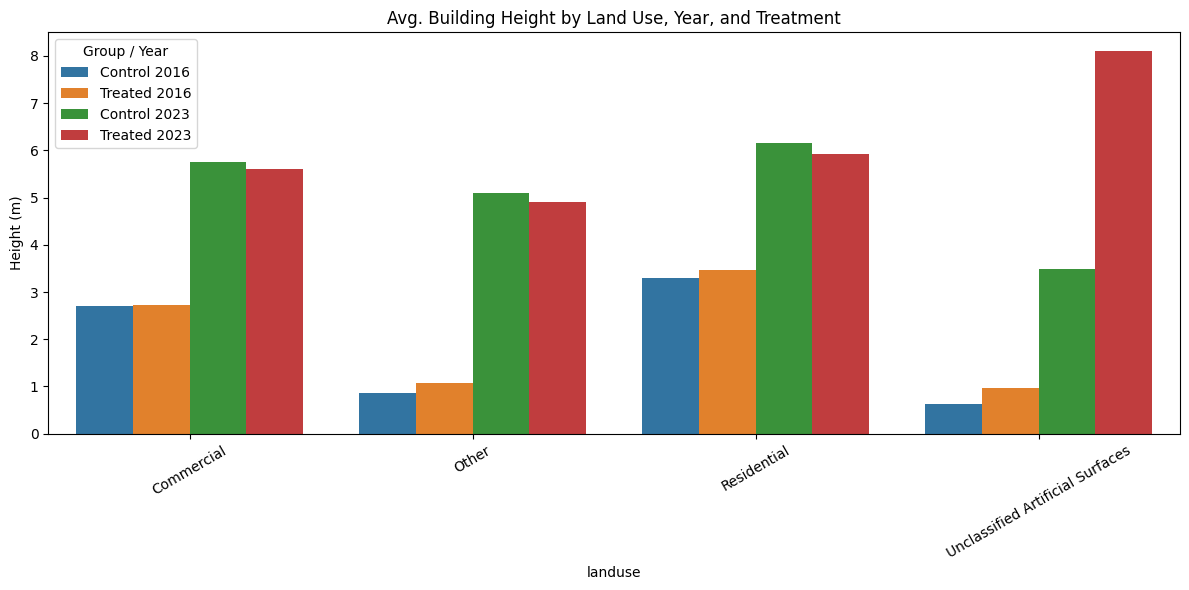

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate mean height per group
grouped = df.groupby(["landuse", "post", "treatment"])["height"].mean().reset_index()
grouped["Year"] = grouped["post"].map({0: "2016", 1: "2023"})
grouped["Group"] = grouped["treatment"].map({0: "Control", 1: "Treated"})

# Create combined label: e.g., 'Control 2016', 'Treated 2023'
grouped["Group_Year"] = grouped["Group"] + " " + grouped["Year"]

# Plot with Group-Year as hue
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x="landuse", y="height", hue="Group_Year", ci=None)

plt.title("Avg. Building Height by Land Use, Year, and Treatment")
plt.ylabel("Height (m)")
plt.xticks(rotation=30)
plt.legend(title="Group / Year")
plt.tight_layout()
plt.show()
plt.savefig("../output/1_2control/height_by_landuse_year_group.png")